In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [8]:
# --- Load FITS image ---
with fits.open("/Users/sarayu/Downloads/m31bH.fits") as hdul:
    data = hdul[0].data.astype(np.float32)
data = (data - np.min(data)) / (np.max(data) - np.min(data))  # normalize


In [9]:
# --- Patch extraction ---
def extract_patches(image, patch_size=128, stride=128):
    patches = []
    h, w = image.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)

patches = extract_patches(data)

In [10]:
# --- Dataset ---
class FITSDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        x = self.patches[idx]
        x = np.expand_dims(x, 0)  # [C, H, W]
        return torch.tensor(x, dtype=torch.float32)

loader = DataLoader(FITSDataset(patches), batch_size=1)

In [17]:
# --- PSF Layer ---
class PSFLayer(nn.Module):
    def __init__(self, kernel_size=15):
        super().__init__()
        self.kernel = nn.Parameter(torch.randn(1, 1, kernel_size, kernel_size))
        self.padding = kernel_size // 2
    def forward(self, x):
        kernel = F.softmax(self.kernel.view(1, 1, -1), dim=-1).view_as(self.kernel)
        return F.conv2d(x, kernel, padding=self.padding)

In [18]:
# --- Generator (for both blurry→sharp and sharp→blurry) ---
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)

G_AB = Generator()       # Blurry → Sharp
G_BA = Generator()       # Sharp → Blurry
psf = PSFLayer()

In [19]:
# --- Optimizer ---
params = list(G_AB.parameters()) + list(G_BA.parameters()) + list(psf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()

In [20]:
# --- Training loop ---
for epoch in range(1):
    for i, x_blurry in enumerate(loader):
        x_sharp_pred = G_AB(x_blurry)
        x_blurry_recon = psf(G_BA(x_sharp_pred))
        loss = loss_fn(x_blurry_recon, x_blurry)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 5 == 0:
            print(f"Batch {i} | Loss: {loss.item():.4f}")

Batch 0 | Loss: 0.0235
Batch 5 | Loss: 0.0083
Batch 10 | Loss: 0.0016
Batch 15 | Loss: 0.0000
Batch 20 | Loss: 0.0004
Batch 25 | Loss: 0.0008
Batch 30 | Loss: 0.0006
Batch 35 | Loss: 0.0001
Batch 40 | Loss: 0.0000
Batch 45 | Loss: 0.0001
Batch 50 | Loss: 0.0001
Batch 55 | Loss: 0.0000
Batch 60 | Loss: 0.0000
Batch 65 | Loss: 0.0000
Batch 70 | Loss: 0.0000
Batch 75 | Loss: 0.0000
Batch 80 | Loss: 0.0000
Batch 85 | Loss: 0.0000
Batch 90 | Loss: 0.0000
Batch 95 | Loss: 0.0001
Batch 100 | Loss: 0.0000
Batch 105 | Loss: 0.0000
Batch 110 | Loss: 0.0000
Batch 115 | Loss: 0.0000
Batch 120 | Loss: 0.0001
Batch 125 | Loss: 0.0000
Batch 130 | Loss: 0.0000
Batch 135 | Loss: 0.0000
Batch 140 | Loss: 0.0000
Batch 145 | Loss: 0.0000
Batch 150 | Loss: 0.0001
Batch 155 | Loss: 0.0000
Batch 160 | Loss: 0.0000
Batch 165 | Loss: 0.0000
Batch 170 | Loss: 0.0000
Batch 175 | Loss: 0.0000
Batch 180 | Loss: 0.0000
Batch 185 | Loss: 0.0000
Batch 190 | Loss: 0.0000
Batch 195 | Loss: 0.0000
Batch 200 | Loss: 0.00

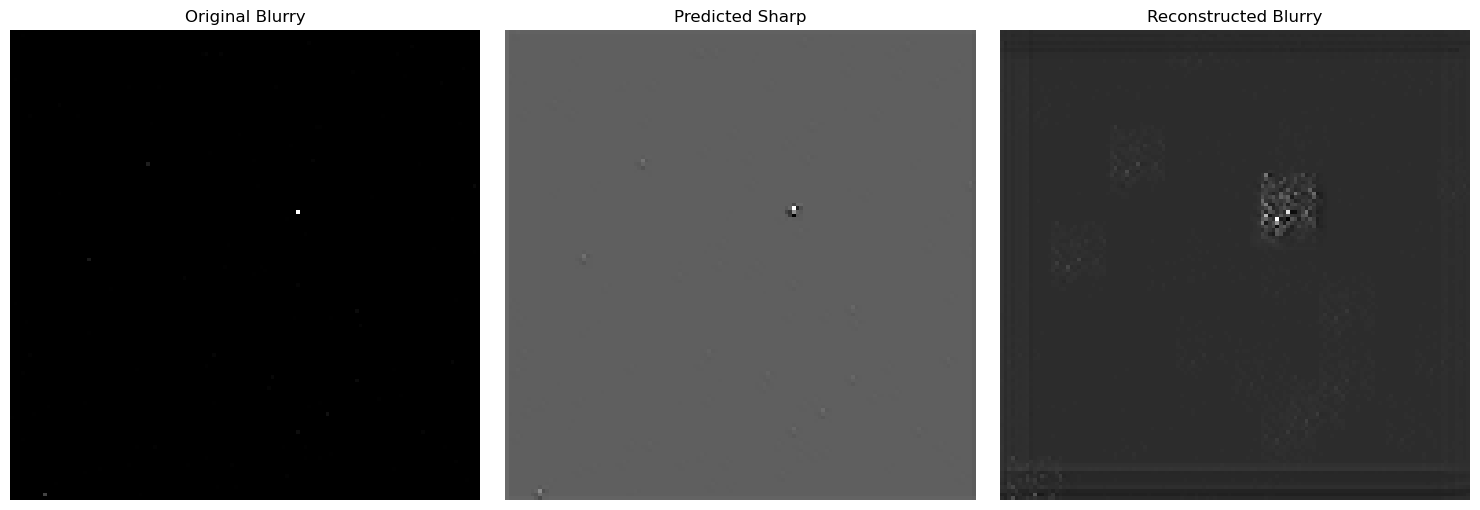

In [21]:
# --- Visualization ---
x_blurry = next(iter(loader))
x_sharp_pred = G_AB(x_blurry).detach()
x_blurry_recon = psf(G_BA(x_sharp_pred)).detach()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_blurry[0,0], cmap='gray'); axs[0].set_title("Original Blurry")
axs[1].imshow(x_sharp_pred[0,0], cmap='gray'); axs[1].set_title("Predicted Sharp")
axs[2].imshow(x_blurry_recon[0,0], cmap='gray'); axs[2].set_title("Reconstructed Blurry")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()